In [1]:
import pandas as pd
import numpy as np
import math
from matplotlib import pyplot as plt
import os
import sys
from scipy.interpolate import griddata
from tqdm import tqdm
# sys.path.append('/Users/jiarong/Google Drive/codes/jiarongw-postprocessing/functions')
sys.path.append('/home/jiarong/research/postprocessing/functions/')
from Amplitude import Amplitude
from fio import readin

In [2]:
os.chdir('/home/jiarong/research/projects/windwave/linear_m5B0Ustar0.5ak0.05Bo3.45Re31000.LEVEL11')
field = readin('eta%g' %0)

/home/jiarong/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:392: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/home/jiarong/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
/home/jiarong/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:68: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


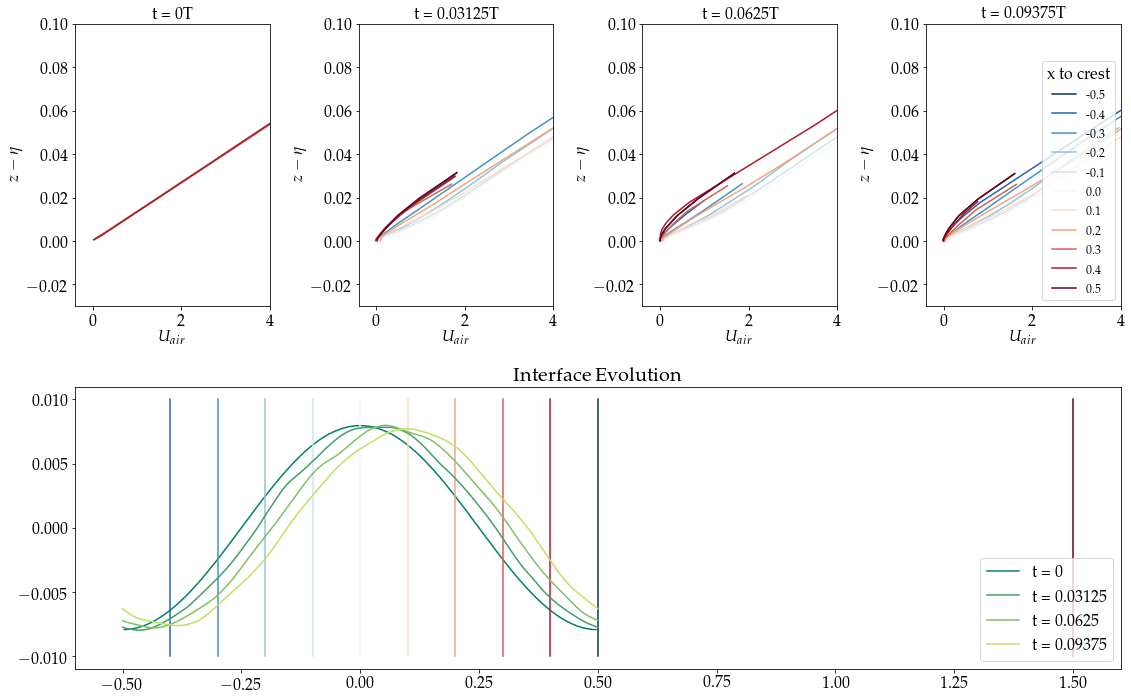

In [3]:
import matplotlib.gridspec as gridspec
from matplotlib import rc
from matplotlib import rcParams
# rc('font',**{'family':'sans-serif','sans-serif':['DejaVu Sans']})
# rc('font',**{'family':'serif','serif':['DejaVu Serif Display']})
rc('text', usetex=True)
rc('font',**{'family':'serif','serif':['Palatino']})
rc('font', size=16)
rc('axes', titlesize=16)

eps = 5*10**(-3) # eps is a value by trial
fig = plt.figure(figsize = [16, 10])
gs = gridspec.GridSpec(2, 4)
ax2 = fig.add_subplot(gs[1,:])

def plot_snapshot(number, t):
    ax = fig.add_subplot(gs[0, number])
    eta_sorted = eta.sort_values(by = ['x'])
    ax2.plot(eta_sorted.x, eta_sorted.pos, label = 't = %g' %t, color=plt.cm.get_cmap('summer')(number/4))
    # get the crest position
    crest = np.array(eta[eta['pos']==eta['pos'].max()].x)
    x_crest = np.average(crest)
    X = np.linspace(-0.5, 0.5, 11, endpoint=True)
    color_idx = np.linspace(1, 0, 11)
    for i,x in enumerate(X):
        if ((x_crest+x) < 0.5) & ((x_crest+x) > -0.5):
            x_relative = x_crest + x 
        elif (x_crest+x) > 0.5: # subtract one period if it's out of the right boundary
            x_relative = x_crest + x - 1
        else: # add one period if it's out of the left boundary
            x_relative = 1 + (x_crest + x)
        if number == 0:
            ax2.plot(x_relative*np.ones(100), np.linspace(-0.01, 0.01, 100, endpoint=True), 
                 color=plt.cm.get_cmap('RdBu')(color_idx[i]))       
        field_slice = field[np.abs(field.x - x_relative) < eps] 
        field_slice = field_slice.sort_values(by = ['y'])
        # get the interface elevation
        eta_slice = eta[np.abs(eta.x - x_relative) < eps]
        eta_x = np.average(eta_slice.pos) 
        field_slice = field_slice[field_slice.y-eta_x >= 0]
        # Good function: average over entry of the same y
        field_samey = field_slice.groupby('y',as_index=False).mean()
        ax.plot(field_samey['u.x'], field_samey.y - eta_x, label = '%1.1f' %x, 
                color=plt.cm.get_cmap('RdBu')(color_idx[i]))   
        ax.set_ylim([-0.03, 0.1])
        ax.set_xlim([-0.4, 4])
        ax.set_xlabel('$U_{air}$')
        ax.set_ylabel('$z-\eta$')
#     ax.legend(title = 'x to crest', loc = 'lower right', fontsize = 12)
    ax.set_title('t = %gT' %t)
    return ax

t_set = [0, 0.03125, 0.0625, 0.09375]
for i, t in enumerate(t_set):
    eta = pd.read_table('./eta%g' %t, delimiter = ',')
    eta = eta[(abs(1-eta.f)>1e-4)&eta.f>1e-4]
    field = pd.read_table('./field_direct%g' %t, delimiter = ',')
    ax = plot_snapshot(i, t)


# To add legend for the figure
# handles, labels = ax.get_legend_handles_labels()
# fig.legend(handles, labels, title = 'x to crest', loc = 'upper right', fontsize = 12)
ax.legend(title = 'x to crest', loc = 'lower right', fontsize = 12)
ax2.legend(loc = 'lower right')
ax2.set_title('Interface Evolution', fontsize = 20)
fig.tight_layout()
fig.show()

To read in and generate animation with a standalone colorbar (from estimation):

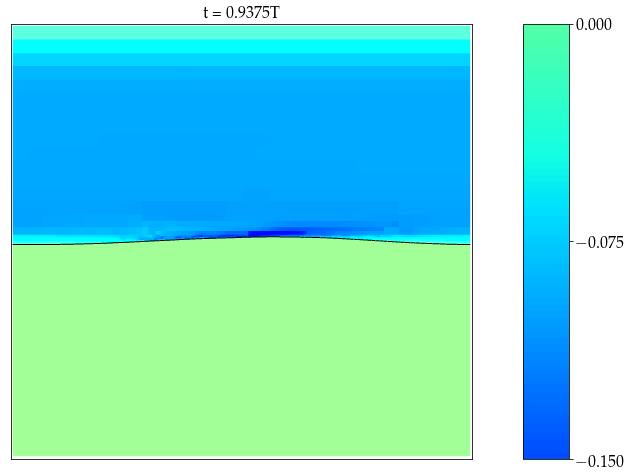

In [58]:
# How to speed up matplotlib
# https://stackoverflow.com/questions/8955869/why-is-plotting-with-matplotlib-so-slow
from matplotlib import animation
from visualization import contour
from IPython.display import HTML
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.colors as mcolors
import matplotlib.image as mpimg

# Single animation generation function
def plot_animation(animate_function, frame_number = 31, interval_time = 100):

    # First set up the figure, the axis, and the plot element we want to animate    
    fig = plt.figure(figsize = [10, 8])
    gs = gridspec.GridSpec(1, 2, width_ratios=[10, 1])
    ax = [plt.subplot(g) for g in gs]

    # The tick numbers and also the upper and lower bounds of the data
    parameterToColorBy = np.linspace(-0.15, 0, 3, dtype=float)

    def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=-1):
        if n == -1:
            n = cmap.N
        new_cmap = mcolors.LinearSegmentedColormap.from_list(
             'trunc({name},{a:.2f},{b:.2f})'.format(name=cmap.name, a=minval, b=maxval),
             cmap(np.linspace(minval, maxval, n)))
        return new_cmap

    # The range of the actual colormap we want to use, and which colormap
    minColor = 0.2
    maxColor = 0.45
    jet_t = truncate_colormap(plt.get_cmap("jet"), minColor, maxColor)
    colors = [jet_t(i) for i in np.linspace(0, 1, parameterToColorBy.shape[0])]
    norm = mpl.colors.Normalize(parameterToColorBy[0],
                                parameterToColorBy[-1])
    # Plot the colorbar in ax[1] (righthand side)
    cb = mpl.colorbar.ColorbarBase(ax[1],
                                   cmap=jet_t,
                                   norm=norm,
                                   ticks=parameterToColorBy,
                                   orientation='vertical')

    # animation function.  This is called sequentially
    def animate(i):
        t = i
        imgplot = animate_function(i, ax[0])
        return imgplot,

    # call the animator.  blit=True means only re-draw the parts that have changed.
    anim = animation.FuncAnimation(fig, animate, frames=frame_number, interval=interval_time, blit = True)  
    return anim

# Define the function called at every animation time to read in images
def plot_func(i, ax):
    t = i/32
    img = mpimg.imread('omega%g' % t)
    image = ax.imshow(img, aspect='equal')
    ax.set_aspect('auto')
    ax.set_xlim([62, 538]) # Visual range
    ax.set_ylim([538, 62])
    ax.set_title('t = %gT' %t)
    ax.get_xaxis().set_visible(False) # Hide the axis
    ax.get_yaxis().set_visible(False)
    return image

os.chdir('/home/jiarong/research/projects/windwave/linear_m5B0Ustar0.5ak0.05Bo3.45Re31000.LEVEL11')
anim = plot_animation(plot_func, frame_number = 31, interval_time = 100) # Specify frame number
HTML(anim.to_html5_video())

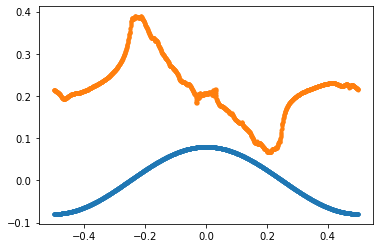

In [29]:
plt.plot(field.x, field.pos*10, '.')
plt.plot(field.x, field.p_p2, '.')

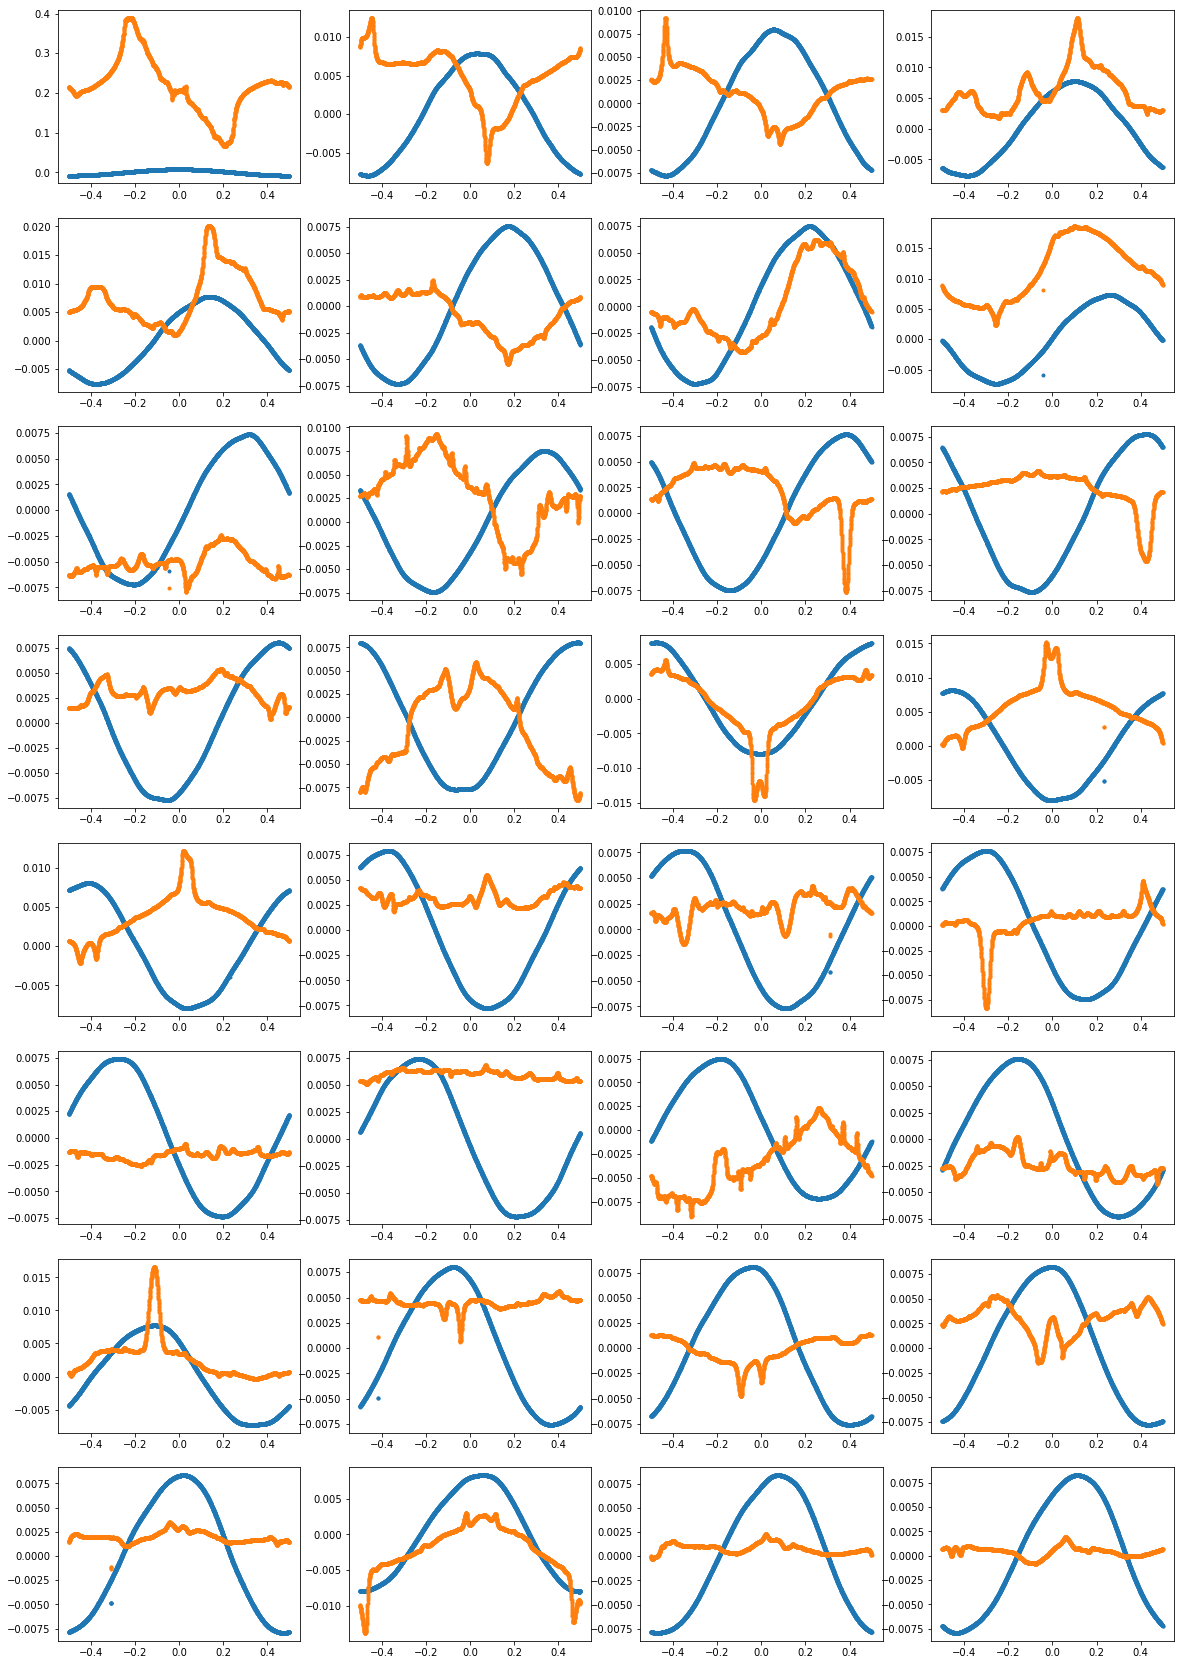

In [33]:
fig, ax = plt.subplots(ncols=4, nrows=8, figsize = [20, 30])  
ncols = 4
N = 32
tau_f = np.zeros(N)
tau_f1 = np.zeros(N)
tau_f2 = np.zeros(N)   # the form stress
s_t = np.zeros(N)   # the viscous energy input
t = np.zeros(N)
for i in range(0, N):   
    # plot the elevation
    t[i] = (i)*1./32
    field = readin('eta%g' %t[i])
    ax[int(i/ncols)][int(i%ncols)].plot(field.x, field.pos, '.')
    ax[int(i/ncols)][int(i%ncols)].plot(field.x, field.p_p2, '.')